In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import matplotlib.pyplot as plt

from importlib import reload

import models
import plotting
import dataloaders as dl
import traintest as tt

Files already downloaded and verified
Files already downloaded and verified


In [2]:
if torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')

In [250]:
preproc = dl.X_MNIST.view(3000,28,28).mean(dim=0)
preproc_std = torch.ones(28,28)
temp = dl.X_MNIST.view(3000,28,28).std(dim=0)
preproc_std[temp>.1] = temp[temp>.1]
base_model = models.LeNet(preproc=(preproc,preproc_std)).to(device)

In [251]:
lr = .01
momentum = .9

optimizer_base = optim.SGD(base_model.parameters(), lr=lr, momentum=momentum, weight_decay=0.005)
for epoch in range(2):
    optimizer_base.param_groups[0]['lr'] *= .8
    tt.train(base_model, device, dl.train_loader, optimizer_base, epoch)

Train Epoch: 0 [0/60000 (0%)]	Loss: 2.302262
Train Epoch: 0 [10000/60000 (17%)]	Loss: 0.234971
Train Epoch: 0 [20000/60000 (33%)]	Loss: 0.159407
Train Epoch: 0 [30000/60000 (50%)]	Loss: 0.114159
Train Epoch: 0 [40000/60000 (67%)]	Loss: 0.042410
Train Epoch: 0 [50000/60000 (83%)]	Loss: 0.108886
Train Epoch: 1 [0/60000 (0%)]	Loss: 0.054936
Train Epoch: 1 [10000/60000 (17%)]	Loss: 0.032103
Train Epoch: 1 [20000/60000 (33%)]	Loss: 0.013162
Train Epoch: 1 [30000/60000 (50%)]	Loss: 0.020905
Train Epoch: 1 [40000/60000 (67%)]	Loss: 0.088888
Train Epoch: 1 [50000/60000 (83%)]	Loss: 0.045417


In [5]:
torch.save(base_model, 'SavedModels/base_model.pth')

In [3]:
base_model = torch.load('SavedModels/base_model.pth')
gmm = models.GMM(1000, 784)
gmm.find_solution(dl.X_MNIST, initialize=True, iterate=False, use_kmeans=False)
gmm_model = models.RobustModel(base_model, gmm, -7.).to(device)
torch.save(gmm_model, 'SavedModels/gmm_model.pth')

In [ ]:
pca_metric = models.PCAMetric(dl.X_MNIST)

base_model = torch.load('SavedModels/base_model.pth')
gmm_pca = models.GMM(300, 784, metric=pca_metric)
gmm_pca.find_solution(dl.X_MNIST, initialize=True, iterate=False, use_kmeans=False)
gmm_model_pca = models.RobustModel(base_model, gmm_pca, -4.5).to(device)
torch.save(gmm_model_pca, 'SavedModels/gmm_model_pca.pth')

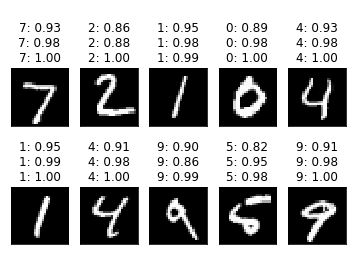

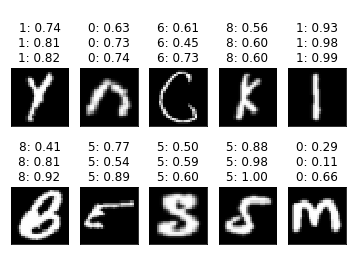

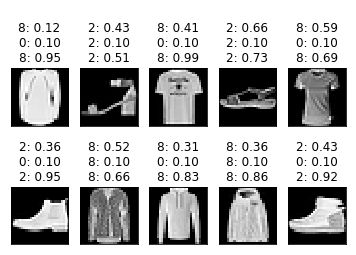




Test set: Average loss: 0.1386, Accuracy: 9853/10000 (99%), Ave. Confidence: 89%


Test set: Average loss: 0.0825, Accuracy: 9760/10000 (98%), Ave. Confidence: 94%


Test set: Average loss: 0.0353, Accuracy: 9880/10000 (99%), Ave. Confidence: 98%


Ave. Confidence: 63% Predicted: 71%


Ave. Confidence: 61% Predicted: 64%


Ave. Confidence: 79% Predicted: 88%



0.7870442269398616

In [98]:
#gmm_model.loglam.data = torch.tensor(-8., device=device)

data = enumerate(dl.test_loader).__next__()[1][0]
y = gmm_model(data.to(device))
y2 = gmm_model_pca(data.to(device))
y_base = base_model(data.to(device))

plotting.plot_samples([y, y2, y_base], data)

data = enumerate(dl.EMNIST_test_loader).__next__()[1][0]
y = gmm_model(data.to(device))
y2 = gmm_model_pca(data.to(device))
y_base = base_model(data.to(device))

plotting.plot_samples([y, y2, y_base], data)

data = enumerate(dl.fashion_train_loader).__next__()[1][0]
y = gmm_model(data.to(device))
y2 = gmm_model_pca(data.to(device))
y_base = base_model(data.to(device))

plotting.plot_samples([y, y2, y_base], data)

min_conf = .5
tt.test(gmm_model, device, dl.test_loader, min_conf=min_conf)
tt.test(gmm_model_pca, device, dl.test_loader, min_conf=min_conf)
tt.test(base_model, device, dl.test_loader, min_conf=min_conf)

tt.test_adv(gmm_model, device, dl.EMNIST_test_loader, min_conf=min_conf)
tt.test_adv(gmm_model_pca, device, dl.EMNIST_test_loader, min_conf=min_conf)
tt.test_adv(base_model, device, dl.EMNIST_test_loader, min_conf=min_conf)

In [41]:
data = enumerate(dl.test_loader).__next__()[1][0]

y = gmm_model(data.to(device))
y_base = base_model(data.to(device))

plotting.plot_samples([y, y_base], data)

In [92]:
gmm_model_pca.mm.logvar.data+=1.5

In [93]:
gmm_model_pca.mm.logvar.exp()

tensor([0.0336, 0.1836, 0.0856, 0.2446, 0.2448, 0.2726, 0.2170, 0.2527, 0.1033,
        0.1410, 0.2192, 0.1696, 0.2098, 0.2078, 0.1589, 0.0803, 0.2035, 0.2356,
        0.1536, 0.2628, 0.1367, 0.2005, 0.0061, 0.1547, 0.1054, 0.2392, 0.1848,
        0.1939, 0.0574, 0.2230, 0.2279, 0.1045, 0.0767, 0.0624, 0.1457, 0.2066,
        0.0985, 0.2401, 0.2103, 0.1898, 0.0612, 0.2050, 0.2493, 0.1667, 0.0780,
        0.1868, 0.1666, 0.2424, 0.3087, 0.0572, 0.2276, 0.1778, 0.2439, 0.1999,
        0.1506, 0.1372, 0.2321, 0.0061, 0.1265, 0.2312, 0.2477, 0.1417, 0.1390,
        0.2461, 0.2265, 0.1874, 0.0680, 0.2174, 0.1199, 0.0891, 0.1563, 0.2263,
        0.1979, 0.1996, 0.1492, 0.1954, 0.2001, 0.2904, 0.1784, 0.2057, 0.0946,
        0.1573, 0.1523, 0.1359, 0.1403, 0.1434, 0.1606, 0.2325, 0.0061, 0.1616,
        0.1766, 0.1730, 0.1866, 0.1662, 0.1917, 0.1543, 0.2146, 0.1402, 0.2291,
        0.2200, 0.1869, 0.2315, 0.2223, 0.0061, 0.2134, 0.0716, 0.0982, 0.1634,
        0.2545, 0.1865, 0.1704, 0.1972, 

In [99]:
torch.save(gmm_model_pca, 'SavedModels/gmm_model_pca.pth')